In [0]:
#default_exp style_transfer

Before we run anything we want to ensure we have a P100 GPU:

In [1]:
!nvidia-smi

Mon Jan 13 06:25:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

If not, run the following:

In [0]:
import torch
data = torch.ones(1000,1000,1000).cuda()

# 05 - Style Transfer
**This notebook is largely based on the work by Lucas Vazquez on the fastai forum**

## What will we cover?

* Custom loss functions
* Custom models
* Utilizing the `nb_dev` library
* Deployment Code

# Intro to `nbdev`

* Library by Jeremy and Sylvain for writing libraries
* Used to make the entire `fastai2` library
* Converts a `ipynb` to documentation as well as `.py` with **only specific cells**

* Few base terminology:
  * `#default_exp`
  * `#hide`
  * `#export`

In [0]:
#hide
#Run once per session
import os
!pip install -q torch feather-format kornia pyarrow wandb nbdev fastprogress --upgrade 
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade
!pip install git+github.com/fastai/fastai2
!pip install git+github.com/fastai/fastcore
os._exit(00)

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 59.2MB 51kB/s 
     |████████████████████████████████| 1.4MB 38.8MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 460kB 38.5MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 2.1MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


In [0]:
#hide
from nbdev.showdoc import *

We always need the `showdoc` to export

# fastai2 libraries

In [0]:
#export
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# What is Style Transfer?

* **Feature Loss**
  * Aka perception loss
* **Image Transformation network**
  * Input images -> Output images
* **Pre-Trained Loss Network**
  * **Perceptual loss functions** 
    * A measurement of the differences in content and style between two images
    
![alt text](https://miro.medium.com/max/1436/0*iwXnji_6lny5slPo)

Source: https://arxiv.org/abs/1603.08155

# Our Pre-Trained Network:
* vgg-19:
  * Small CNN pre-trained on ImageNet
  * Only 19 layers deep

In [0]:
#export
from torchvision.models import vgg19, vgg16

In [0]:
feat_net = vgg19(pretrained=True).features.cuda().eval()

We'll get rid of the head and use the internal activations (and our generator model's loss). As a result, we want to set every layer to un-trainable

In [0]:
for p in feat_net.parameters(): p.requries_grad=False

We will be using feature detections that our model picks up, which is like our heatmaps generated for our Classification models

In [6]:
layers = [feat_net[i] for i in [1, 6, 11, 20, 29, 22]]; layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

The outputs are `ReLU` layers. Below is a configuration for the 16 and 19 models

In [0]:
#export
_vgg_config = {
    'vgg16' : [1, 11, 18, 25, 20],
    'vgg19' : [1, 6, 11, 20, 29, 22]
}

Let's write a quick `get_layers` function to grab our network and the layers

In [0]:
#export 
def _get_layers(arch:str, pretrained=True):
  "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
  feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
  config = _vgg_config.get(arch)
  features = feat_net.features.cuda().eval()
  for p in features.parameters(): p.requires_grad=False
  return feat_net, [features[i] for i in config]

Now let's make it all in one go utilizing our private functions to pass in an architecture name and a `pretrained` parameter

In [0]:
#export
def get_feats(arch:str, pretrained=True):
  "Get the features of an architecture"
  feat_net, layers = _get_layers(arch, pretrained)
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    feat_net(x)
    return hooks.stored
  return _inner

In [0]:
feats = get_feats('vgg19')

# The Loss Function


Our loss fuction needs:

* Our original image
* Some artwork / style
* Activation features from our encoder

What image will we be using?

![alt text](https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg)

Let's grab the image

In [0]:
#export
url = 'https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg'

In [12]:
!wget {url} -O 'style.jpg'

--2020-01-13 06:40:45--  https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg
Resolving static.greatbigcanvas.com (static.greatbigcanvas.com)... 184.73.153.31
Connecting to static.greatbigcanvas.com (static.greatbigcanvas.com)|184.73.153.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445921 (435K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 435.47K  --.-KB/s    in 0.04s   

2020-01-13 06:40:45 (10.0 MB/s) - ‘style.jpg’ saved [445921/445921]



In [0]:
fn = 'style.jpg'

We can now make a `PipeLine` to convert our image into a `Tensor` to use in our loss function

In [0]:
pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), 
                 Normalize.from_stats(*imagenet_stats, cuda=False)])

In [0]:
style_im = TensorImage(pipe(fn).cuda())

In [0]:
#export
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(),
                  Normalize.from_stats(*imagenet_stats, cuda=False)])
  return TensorImage(pipe(fn).cuda())

We can then grab the features using our `feats` function we made earlier

In [0]:
im_feats = feats(style_im)

Let's look at their sizes

In [18]:
for feat in im_feats:
  print(feat.shape)

torch.Size([1, 64, 824, 1000])
torch.Size([1, 128, 412, 500])
torch.Size([1, 256, 206, 250])
torch.Size([1, 512, 103, 125])
torch.Size([1, 512, 51, 62])
torch.Size([1, 512, 103, 125])


Now we can bring those images down to the channel size

In [0]:
#export
def gram(x:Tensor):
  "Transpose a tensor based on c,w,h"
  n, c, h, w = x.shape
  x = x.view(n, c, -1)
  return (x @ x.transpose(1, 2))/(c*w*h)

In [0]:
im_grams = [gram(f) for f in im_feats]

In [21]:
for feat in im_grams:
  print(feat.shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [0]:
#export
def get_stl_fs(fs): return fs[:-1]

We're almost there! Let's look at why that was important

In [0]:
#export
def style_loss(inp:Tensor, out_feat:Tensor):
  "Calculate style loss, assumes we have `im_grams`"
  # Get batch size
  bs = inp[0].shape[0]
  loss = []
  # For every item in our inputs
  for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
    # Calculate MSE
    loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
  # Multiply their sum by 30000
  return 3e5 * sum(loss)

Great, so what now? Let's make a loss function for `fastai2`!
* Remember, we do not care to use any initial metrics

In [0]:
#export
class FeatureLoss(Module):
  "Combines two losses and features into a useable loss function"
  def __init__(self, feats, style_loss, act_loss):
    store_attr(self, 'feats, style_loss, act_loss')
    self.reset_metrics()

  def forward(self, pred, targ):
    # First get the features of our prediction and target
    pred_feat, targ_feat = self.feats(pred), self.feats(targ)
    # Calculate style and activation loss
    style_loss = self.style_loss(pred_feat, targ_feat)
    act_loss = self.act_loss(pred_feat, targ_feat)
    # Store the loss
    self._add_loss(style_loss, act_loss)
    # Return the sum
    return style_loss + act_loss

  def reset_metrics(self):
    # Generates a blank metric
    self.metrics = dict(style = [], content = [])

  def _add_loss(self, style_loss, act_loss):
    # Add to our metrics
    self.metrics['style'].append(style_loss)
    self.metrics['content'].append(act_loss)

In [0]:
#export
def act_loss(inp:Tensor, targ:Tensor):
  "Calculate the MSE loss of the activation layers"
  return F.mse_loss(inp[-1], targ[-1])

Let's declare our loss function by passing in our features and our two 'mini' loss functions

In [0]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

# The Model Architecture
Let's now build our model

In [0]:
class ReflectionLayer(nn.Sequential):
    "A series of ReflectionPad2d with Conv2d and InstanceNorm2d"
    def __init__(self, ni, nf, ks=3, stride=1, norm=True):
        padding = ks // 2
        layers = []
        layers += [nn.ReflectionPad2d(padding)]
        layers += [nn.Conv2d(ni, nf, ks, stride)]
        layers += [nn.InstanceNorm2d(nf, affine=True)] if norm else []
        super().__init__(*layers)

In [28]:
ReflectionLayer(3, 3)

ReflectionLayer(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
)

In [0]:
class ResidualBlock(Module):
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
      self.reflect1 = ReflectionLayer(channels, channels)
      self.reflect2 = ReflectionLayer(channels, channels)
      self.act = MishJit()

    def forward(self, x):
      residual = x
      out = self.reflect2(self.act(self.reflect1(x)))
      out = out + residual
      return out

In [30]:
ResidualBlock(3)

ResidualBlock(
  (reflect1): ReflectionLayer(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (reflect2): ReflectionLayer(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (act): MishJit()
)

In [0]:
class UpsampleConvLayer(Module):
    "Upsample with a ReflectionLayer"
    def __init__(self, ni, nf, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        self.reflect = ReflectionLayer(ni, nf, ks, stride)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=self.upsample)
        return self.reflect(x)

Let's put everything together into a model

In [0]:
class TransformerNet(Module):
    "A simple model for Style Transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        # Residual layers
        self.res = nn.Sequential(*[ResidualBlock(128) for x in range(5)])
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1, norm=False)
        # Non-linearities
        self.act = MishJit()

    def forward(self, x):
        y = self.conv2(self.act(self.conv1(x)))
        y = self.act(self.conv3(self.act(y)))
        y = self.res(y)
        y = self.deconv2(self.act(self.deconv1(y)))
        y = self.deconv3(self.act(y))
        return y

In [0]:
net = TransformerNet()

# DataLoaders and Learner

We will be using the `COCO_SAMPLE` dataset

In [0]:
path = untar_data(URLs.COCO_SAMPLE)

Our `DataBlock` needs to be Image -> Image

In [0]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42))

If you do not pass in a `get_y`, `fastai2` will assume your input = output

In [0]:
dbunch = dblock.dataloaders(path, bs=22, item_tfms=[Resize(224)],
                       batch_tfms=[Normalize.from_stats(*imagenet_stats)])

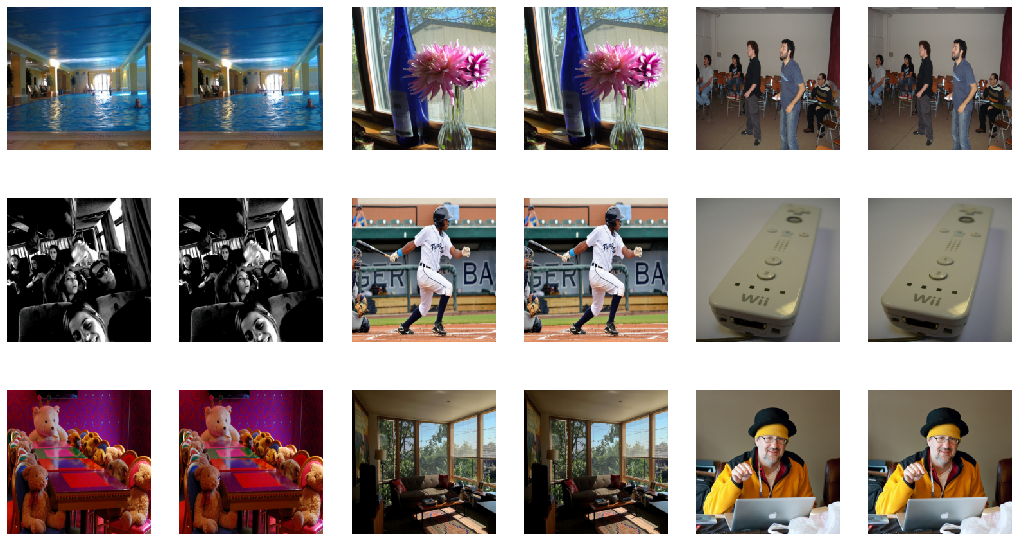

In [57]:
dbunch.show_batch()

We now can make our `Learner`!

In [0]:
learn = Learner(dbunch, net, loss_func=loss_func)

In [0]:
learn.summary()

TransformerNet (Input shape: 22 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
ReflectionPad2d      22 x 3 x 232 x 232   0          False     
________________________________________________________________
Conv2d               22 x 32 x 224 x 224  7,808      True      
________________________________________________________________
InstanceNorm2d       22 x 32 x 224 x 224  64         True      
________________________________________________________________
ReLU                 22 x 32 x 224 x 224  0          False     
________________________________________________________________
ReflectionPad2d      22 x 32 x 226 x 226  0          False     
________________________________________________________________
Conv2d               22 x 64 x 112 x 112  18,496     True      
________________________________________________________________
InstanceNorm2d       22 x 64 x 112 x 112  128        True      
_________________________________________________

Let's find a learning rate and fit for one epoch

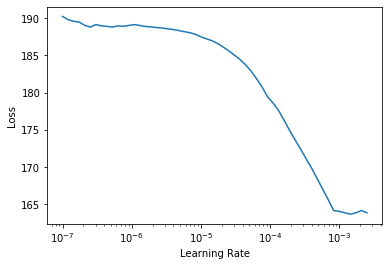

In [0]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,29.346478,29.071646,07:51


In [0]:
learn.save('stage1')

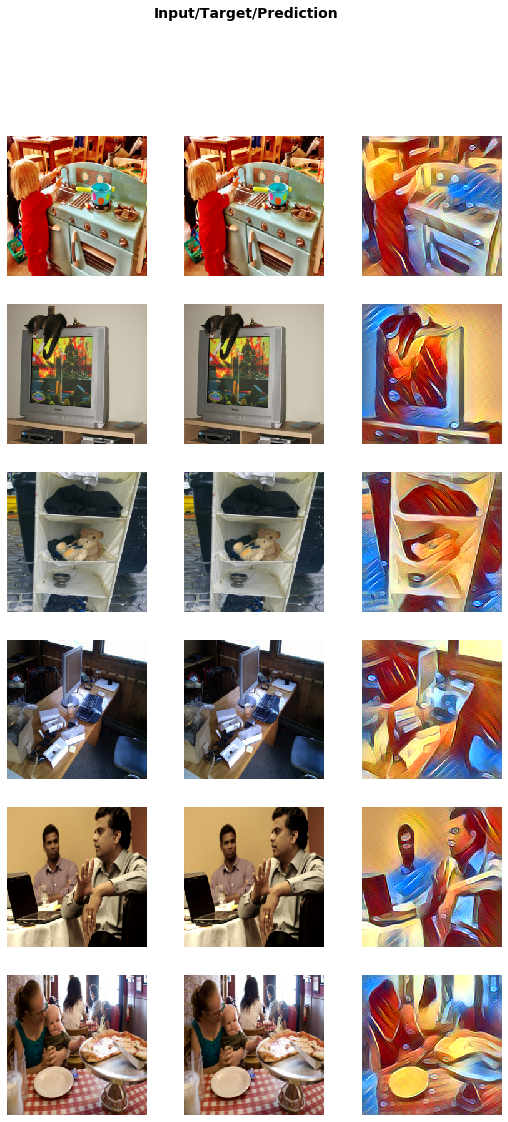

In [39]:
learn.show_results()

In [40]:
pred = learn.predict('Mueller_Headshot.png')

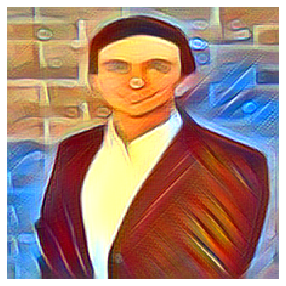

In [41]:
pred[0].show()

In [0]:
learn.save('224')

Now we can increase our size to 512 similar to how we could do in the segmentation example (this is homework, we will not do this as the epoch will take ~40 minutes)

# Homework

In [0]:
dbunch = dblock.dataloaders(path, bs=8, item_tfms=[Resize(512)],
                       batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [0]:
learn = Learner(dbunch, net, loss_func=loss_func).load('224')

In [0]:
learn.fit_one_cycle(1, 1e-3)

In [0]:
learn.show_results()

In [0]:
learn.save('final')

# Rest of the lesson

Let's export our model to use.

In [0]:
learn.loss_func = CrossEntropyLossFlat()

In [0]:
learn.export('myModel')

From here:
Download the notebook and upload it to the main

# Export

In [0]:
#hide
from nbdev.imports import *
from nbdev.export import reset_nbdev_module, notebook2script

create_config('myLib', user='muellerzr', path='.', cfg_name='settings.ini')
cfg = Config(cfg_name='settings.ini')

In [0]:
reset_nbdev_module()

In [0]:
#hide
from nbdev.export import notebook2script
notebook2script('05_StyleTransfer.ipynb')

Converted 05_StyleTransfer.ipynb.
